In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
import pycolmap
from tqdm import tqdm

from hloc.utils import viz_3d, parsers
from hloc.visualization import plot_images, read_image
from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_retrieval, pairs_from_exhaustive, localize_sfm

In [2]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(torch.cuda.get_device_name(0))

1.13.0+cu117
11.7
8500
NVIDIA GeForce RTX 3050 Ti Laptop GPU


## 从无序图像数据集中运行三维重建

配置路径和参数

In [4]:
my_datasets = ['House11', 'SportsHall', 'SportsHall_sparse']  # 11号楼、体育馆
sfm_dataset = Path('datasets/' + my_datasets[1])  # 用于三维重建的数据集

reference_imgs = sfm_dataset / 'reference/'  # 对参考图像数据库运行三维重建
reference_names = [r.relative_to(sfm_dataset).as_posix() for r in reference_imgs.iterdir()]  # 相对于数据集根目录的文件名

query_imgs = sfm_dataset / 'query/'  # 查询图像
query_names = [q.relative_to(sfm_dataset).as_posix() for q in query_imgs.iterdir()]  # 相对于数据集根目录的文件名

outputs = sfm_dataset / 'hloc'  # 与官方不同，将outputs放置在数据集文件夹中

sfm_pairs = outputs / 'sfm_pairs.txt'
sfm_dir = outputs / 'sfm_superpoint+superglue'
loc_pairs = outputs / 'loc_pairs.txt'

retrieval = outputs / 'retrieval.h5'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'

retrieval_conf = extract_features.confs['netvlad']
feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']

query_intrinsics = outputs / 'queries_with_intrinsics.txt'  # 保存查询图像名称和估计的相机参数

通过图像检索在参考图像中寻找图像对

In [3]:
# 由于数据集相对较大，使用NetVLAD提取全局描述符并寻找与每幅图像最相似的图像
# 若数据集较小，直接进行穷举匹配
extract_features.main(retrieval_conf, sfm_dataset, image_list=reference_names, feature_path=retrieval)
pairs_from_retrieval.main(retrieval, sfm_pairs, num_matched=5)

[2022/12/12 16:51:28 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[2022/12/12 16:51:28 hloc INFO] Skipping the extraction.
[2022/12/12 16:51:28 hloc INFO] Extracting image pairs from a retrieval database.
[2022/12/12 16:51:30 hloc INFO] Found 1510 pairs.


提取并匹配参考图像的局部特征

In [4]:
extract_features.main(feature_conf, sfm_dataset, image_list=reference_names, feature_path=features)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches)

[2022/12/12 16:51:32 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
[2022/12/12 16:51:32 hloc INFO] Skipping the extraction.
[2022/12/12 16:51:32 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
[2022/12/12 16:51:32 hloc INFO] Skipping the matching.


PosixPath('datasets/SportsHall/hloc/matches.h5')

运行COLMAP

In [5]:
model = reconstruction.main(sfm_dir, sfm_dataset, sfm_pairs, features, matches, image_list=reference_names)

[2022/12/11 10:39:07 hloc WARNING] The database already exists, deleting it.
[2022/12/11 10:39:07 hloc INFO] Creating an empty database...
[2022/12/11 10:39:07 hloc INFO] Importing images into the database...
[2022/12/11 10:39:12 hloc INFO] Importing features into the database...
100%|██████████| 295/295 [00:00<00:00, 2400.58it/s]
[2022/12/11 10:39:12 hloc INFO] Importing matches into the database...
100%|██████████| 1475/1475 [00:00<00:00, 2965.24it/s]
[2022/12/11 10:39:12 hloc INFO] Performing geometric verification of the matches...
[2022/12/11 10:39:18 hloc INFO] Running 3D reconstruction...
[2022/12/11 10:39:18 hloc INFO] {'num_threads': 16}


run_reconstruction options: {'num_threads': 16}


[2022/12/11 10:43:32 hloc INFO] Reconstructed 2 model(s).
[2022/12/11 10:43:32 hloc INFO] Largest model is #0 with 292 images.
[2022/12/11 10:43:32 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 292
	num_cameras = 292
	num_points3D = 44856
	num_observations = 244497
	mean_track_length = 5.45071
	mean_observations_per_image = 837.318
	mean_reprojection_error = 1.22336
	num_input_images = 295


## 三维重建结果可视化

In [5]:
print(sfm_dir)
model = pycolmap.Reconstruction(sfm_dir)  # 加载三维重建模型
print(model.summary())

datasets/SportsHall/hloc/sfm_superpoint+superglue
Reconstruction:
	num_reg_images = 292
	num_cameras = 292
	num_points3D = 44856
	num_observations = 244497
	mean_track_length = 5.45071
	mean_observations_per_image = 837.318
	mean_reprojection_error = 1.22336


In [ ]:
# 3D可视化
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping")
fig.show()

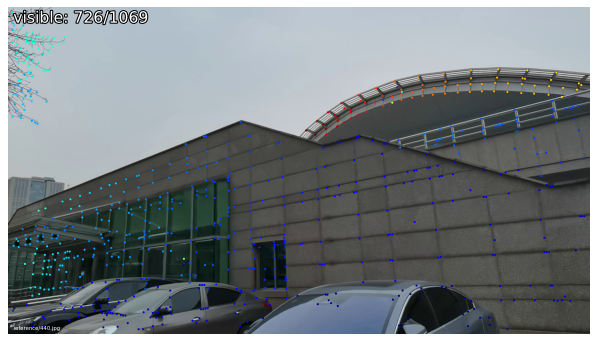

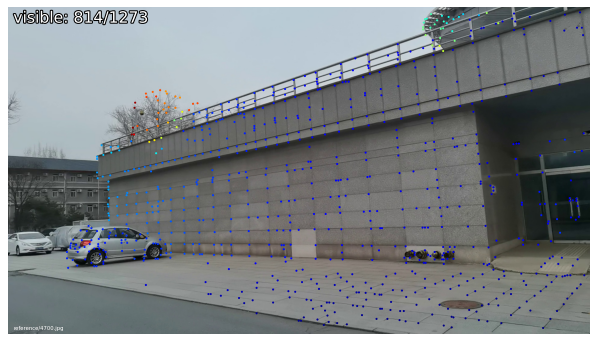

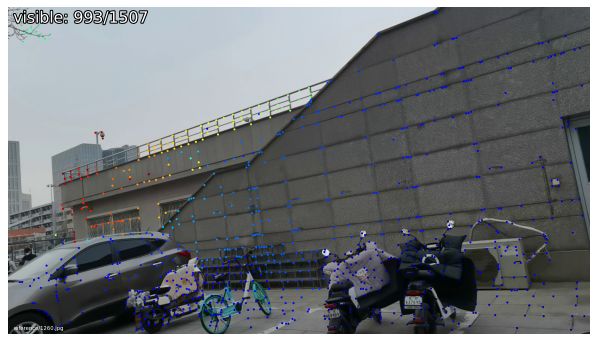

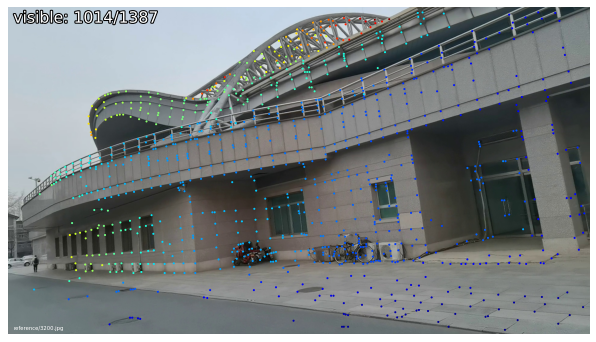

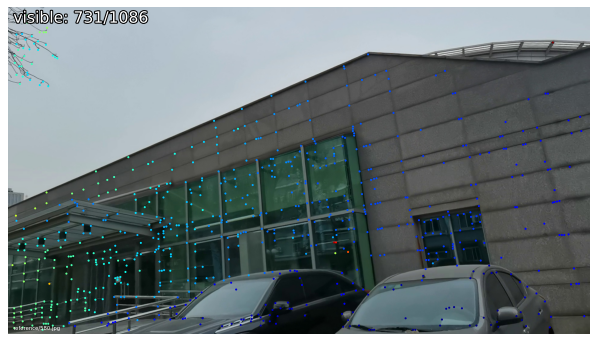

In [8]:
visualization.visualize_sfm_2d(model, sfm_dataset, color_by='depth', n=5)

## 查询图像定位

In [9]:
# plot_images([read_image(sfm_dataset / q) for q in query_names[:5]], dpi=50)

通过图像检索寻找查询图像与参考图像之间的图像对

In [6]:
extract_features.main(retrieval_conf, sfm_dataset, image_list=query_names, feature_path=retrieval, overwrite=True)
pairs_from_retrieval.main(retrieval, loc_pairs, num_matched=20, db_list=reference_names, query_list=query_names)

[2022/12/12 16:52:06 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
100%|██████████| 7/7 [00:01<00:00,  4.65it/s]
[2022/12/12 16:52:12 hloc INFO] Finished exporting features.
[2022/12/12 16:52:12 hloc INFO] Extracting image pairs from a retrieval database.
[2022/12/12 16:52:12 hloc INFO] Found 140 pairs.


提取并匹配局部特征

In [6]:
extract_features.main(feature_conf, sfm_dataset, image_list=query_names, feature_path=features, overwrite=True)
match_features.main(matcher_conf, loc_pairs, features=features, matches=matches, overwrite=True)

[2022/12/12 16:06:42 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}


Loaded SuperPoint model


100%|██████████| 7/7 [00:00<00:00, 15.27it/s]
[2022/12/12 16:06:42 hloc INFO] Finished exporting features.
[2022/12/12 16:06:42 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 140/140 [00:25<00:00,  5.55it/s]
[2022/12/12 16:07:07 hloc INFO] Finished exporting matches.


PosixPath('datasets/SportsHall/hloc/matches.h5')

提取查询图像的特征，并与参考图像穷举匹配

In [12]:
# pairs_from_exhaustive.main(loc_pairs, image_list=query_names, ref_list=reference_names)
# match_features.main(matcher_conf, loc_pairs, features=features, matches=matches, overwrite=True)

定位查询图像，估计相机位姿并优化相机参数

In [5]:
import pycolmap
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

model = pycolmap.Reconstruction(sfm_dir)  # 加载三维重建模型
loc_pairs_dict = parsers.parse_retrieval(loc_pairs)  # 以字典格式存储的查询图像与参考图像的配对
conf = {
    'estimation': {'ransac': {'max_error': 12}},
    'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
}
localizer = QueryLocalizer(model, conf)

In [6]:
# 估计相机位姿并优化相机参数
cameras, rets, logs, poses = [], [], [], []
for i, query in enumerate(query_names):
    camera = pycolmap.infer_camera_from_image(sfm_dataset / query)
    ref_ids = [model.find_image_with_name(r).image_id for r in loc_pairs_dict[query]]  # 与查询图像配对的参考图像的ids
    ret, log = pose_from_cluster(localizer, query, camera, ref_ids, features, matches)
    print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
    pose = pycolmap.Image(tvec=ret['tvec'], qvec=ret['qvec'])
    cameras.append(camera), rets.append(ret), logs.append(log), poses.append(pose)

found 298/906 inlier correspondences.
found 138/502 inlier correspondences.
found 712/1136 inlier correspondences.
found 662/1174 inlier correspondences.
found 349/648 inlier correspondences.
found 608/1526 inlier correspondences.
found 109/334 inlier correspondences.


In [9]:
# 保存查询图像名称和估计的相机参数
with open(query_intrinsics, 'w') as f:
    for i, camera in enumerate(cameras):
        params = " ".join(str(c) for c in camera.params)
        f.write(f'{query_names[i]} {camera.model_name} {camera.width} {camera.height} {params}\n')

In [9]:
# 定位结果3D可视化
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping", cameras=False)  # 可视化sfm模型
for i in range(len(query_names)):
    viz_3d.plot_camera_colmap(fig, poses[i], cameras[i], color='rgba(0,255,0,0.5)', name=i)  # 可视化查询图像相机位姿
fig.show()

In [7]:
# 定位结果2D可视化
for i in range(len(query_names)):
    break
    visualization.visualize_loc_from_log(sfm_dataset, query_names[i], logs[i], model)
